## Import libraries

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

## Setting some parameters

In [3]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)

Device: mps


In [4]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading MNIST from torchvision

In [5]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [6]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


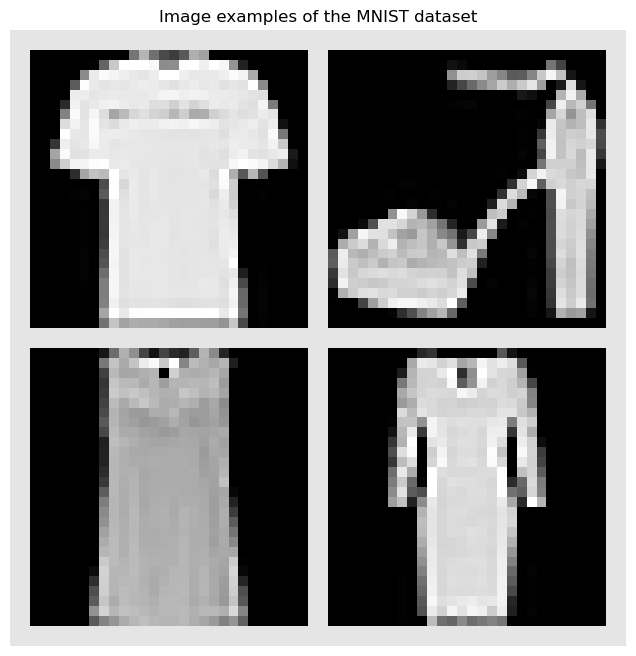

In [7]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Visualizing `img_to_patch` function

In [8]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

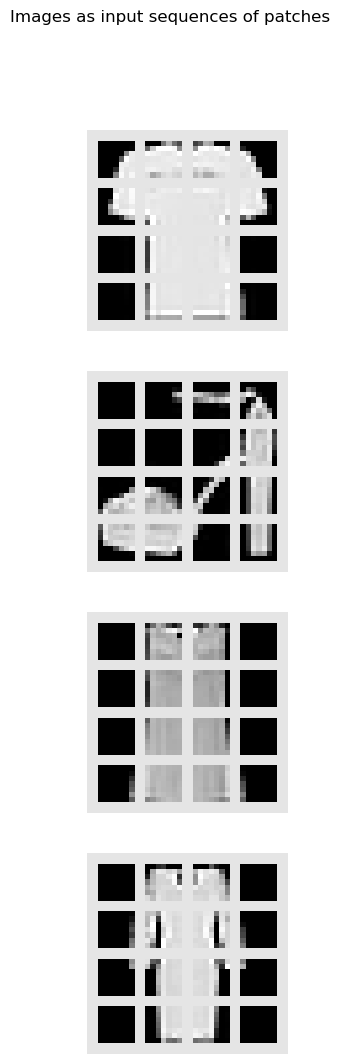

In [9]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

## VisionTransformer class

In [10]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [11]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## Initializing the model

In [12]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [13]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=255, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=255, out_features=765, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=765, out_features=255, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): Layer

## Training

In [14]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(1):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch+1)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = './model_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3100 valid 0.4408


Text(0.5, 1.0, 'Training loss')

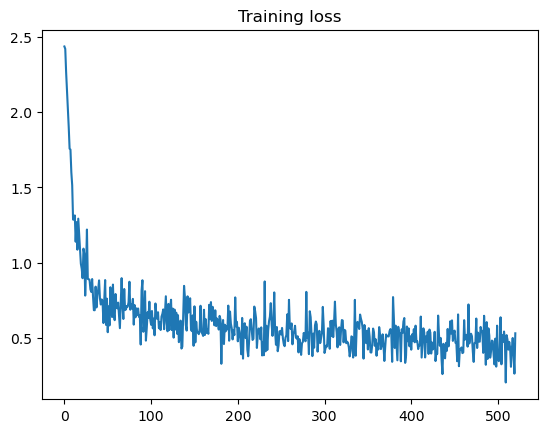

In [15]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [16]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.8307


## Picking one test sample and running it through the attention block

In [42]:
test_sample_index = (test_set.targets==0).nonzero(as_tuple=True)[0][22].item()
print(test_sample_index)
img_tensor = test_set.data[test_sample_index].to(device)
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
patches = model.input_layer(patches.float())
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding

223


## Plotting attention


In [43]:
# Funzione per il rollout dell'attenzione
def attention_rollout_function(attn_maps):
    attn_rollout = []
    I = torch.eye(attn_maps[0].shape[-1]).to(attn_maps[0].device)  # Matrice identità sulla corretta device
    prod = I
    for i, attn_map in enumerate(attn_maps):
        # Somma dell'attenzione con la matrice identità (residual connection)
        prod = prod @ (attn_map + I)  
        
        # Normalizzazione
        prod = prod / prod.sum(dim=-1, keepdim=True) 
        attn_rollout.append(prod)
    return attn_rollout

In [44]:
# Funzione per estrarre le matrici di attenzione attraverso i livelli del vit
def extract_attention_maps(model, transformer_input, num_heads, device):
    attn_maps = []

    for block in model.transformer:
        
        # Estrai il tensore linearizzato del blocco
        transformer_input_expanded = block.linear[0](transformer_input).squeeze(0)
        
        # Reshape del risultato dell'attenzione
        qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
        q = qkv[0]  # Matrice delle query (num_heads, num_patches + 1, embedding_size // num_heads)
        k = qkv[1]  # Matrice delle key (num_heads, num_patches + 1, embedding_size // num_heads)
        
        # Moltiplicazione di q e k^T per ottenere le matrici di attenzione per ciascuna head
        kT = k.transpose(-2, -1)  # Trasposizione per la moltiplicazione corretta
        attention_matrices = torch.matmul(q, kT)  # Dim: (num_heads, num_patches + 1, num_patches + 1)

        # Aggiunta delle connessioni residue e normalizzazione
        residual_att = torch.eye(attention_matrices.size(-1)).to(device)
        aug_att_mats = attention_matrices + residual_att
        aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)

        # Media su tutte le teste di attenzione
        avg_attention = aug_att_mats.mean(dim=0)  # Media delle heads

        # Aggiungi la matrice di attenzione alla lista
        attn_maps.append(avg_attention)

    return attn_maps

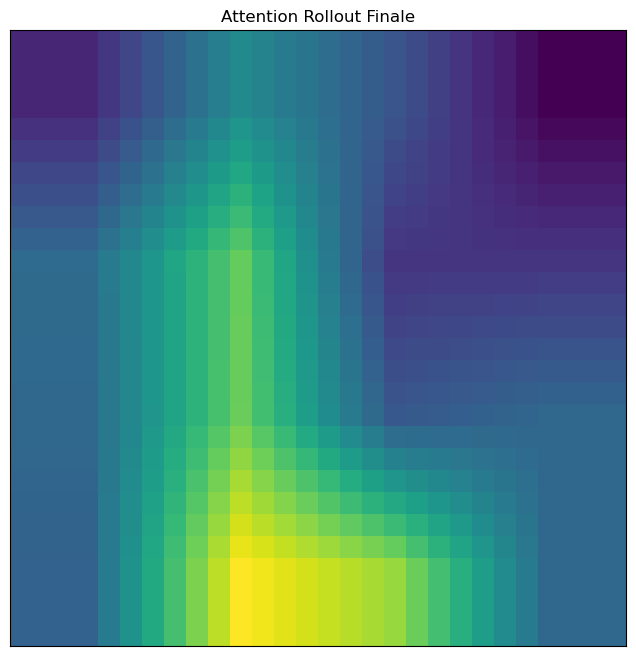

In [45]:
# Estrai le mappe di attenzione
attn_maps = extract_attention_maps(model, transformer_input, num_heads, device)

# Esegui il rollout sulle mappe di attenzione estratte
rollout_matrices = attention_rollout_function(attn_maps)

# Visualizza il risultato del rollout finale
final_rollout = rollout_matrices[-1]  # La matrice finale dopo il rollout di tutti i livelli

# Visualizzazione delle heatmap dell'attenzione rollout finale
fig, ax = plt.subplots(figsize=(8, 8))
attn_heatmap = final_rollout[0, 1:].reshape((int(image_size / patch_size), int(image_size / patch_size)))
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
ax.imshow(attn_heatmap_resized.detach().cpu().numpy(), cmap='viridis')
ax.set_title('Attention Rollout Finale')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()

attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


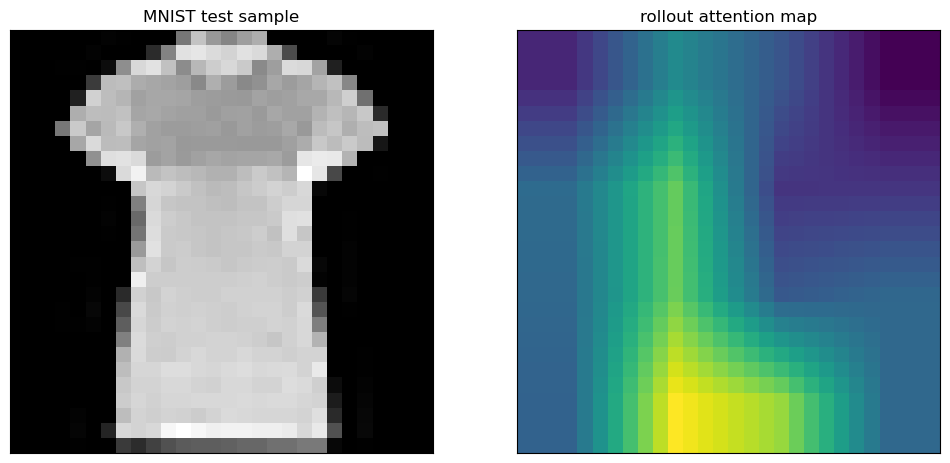

In [46]:
attn_heatmap = final_rollout[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('rollout attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)